In [1]:
#Importing the libraries
import six
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.modules['sklearn.externals.six'] = six
import warnings
warnings.filterwarnings(action="ignore",category=FutureWarning)

In [2]:
#add configs
pd.set_option('mode.chained_assignment', None)
pd.options.display.float_format='{:,.4f}'.format

In [3]:
#importing data 
df=pd.read_excel("data/data.xlsx",sheet_name="Raw Data")

In [4]:
#Analyzing the features
print((df.isnull().sum()/df.shape[0])*100)

Transaction Id     0.0000
Odds               0.0000
Status             0.0000
Winlost            0.0000
LiveIndicator      0.0000
Betteam            0.0000
Winlostdate        0.0000
ActualRate         0.0000
MatchId            0.0000
Bettype            0.0000
Actual_Stake       0.0000
Currency           0.0000
LeagueId           0.0000
Transaction Date   0.0000
WebSite Id         0.0000
MaxBet             2.6675
dtype: float64


In [5]:
#1. Please find the total Player's stake in SGD.
df["Stake_SGD"]=df["ActualRate"]*df["Actual_Stake"]
round(df[df["Actual_Stake"]<=df["MaxBet"]]["Stake_SGD"].sum(),2)

24130425.46

In [6]:
#2. From your observations of the data provided, please share 5 or more insights that you may have.


In [7]:
#3. Predict the Actual Stake of the English Premier League of each currency for the following week from this set of data. Kindly provide your assumptions and explanations.

#select premier league data
premier=df[df["LeagueId"]==3]

#asignar como variables  los segmentos del df por currency
for currency in premier['Currency'].unique():
    globals()[f'premier_{currency}'] = premier[premier['Currency'] == currency]

                Transaction Id    Odds  Winlost  LiveIndicator  ActualRate  \
Transaction Id          1.0000 -0.0044   0.0113        -0.0248     -0.1340   
Odds                   -0.0044  1.0000  -0.0015        -0.1216      0.0495   
Winlost                 0.0113 -0.0015   1.0000        -0.0108     -0.0065   
LiveIndicator          -0.0248 -0.1216  -0.0108         1.0000     -0.0249   
ActualRate             -0.1340  0.0495  -0.0065        -0.0249      1.0000   
MatchId                 0.0088 -0.0126   0.0016         0.0923     -0.0174   
Bettype                -0.0071  0.1433  -0.0051         0.1470      0.0136   
Actual_Stake            0.0165 -0.0017   0.7967        -0.0153     -0.0095   
LeagueId                   NaN     NaN      NaN            NaN         NaN   
WebSite Id             -0.2809 -0.0368  -0.0063         0.0547     -0.0333   
MaxBet                  0.0058 -0.0124   0.2441        -0.0216     -0.0475   
Stake_SGD               0.0169 -0.0246   0.1124        -0.0436  

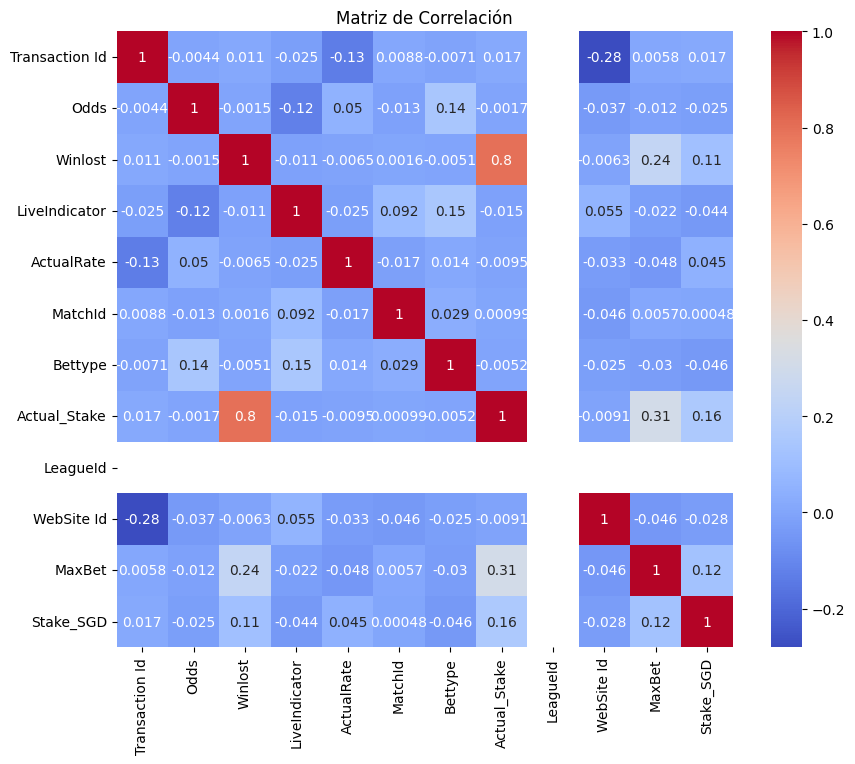

In [8]:
#Check Correlation
# Calcula la correlación entre las variables
corr_matrix = premier.corr()

# Muestra la matriz de correlación
print(corr_matrix)

# Grafica la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Matriz de Correlación')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

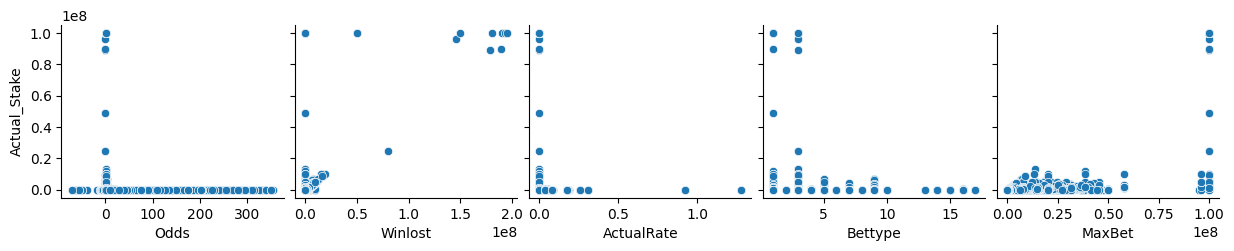

In [9]:
# Grafica la correlación entre las variables y la variable objetivo 'Actual_Stake'
plt.figure(figsize=(10, 6))
sns.pairplot(df, x_vars=['Odds', 'Winlost', 'ActualRate', 'Bettype', 'MaxBet'], y_vars='Actual_Stake')
plt.show()

In [10]:
#ML
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, pacf, acf

df=premier_CNY

# Convertir Transaction Date a datetime
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])

# Establecer Transaction Date como índice
df.set_index('Transaction Date', inplace=True)

# Reordenar índice de fecha
df.sort_index(inplace=True)

# Eliminar fechas duplicadas y NaN
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Establecer frecuencia del índice de fecha
df.index = pd.date_range(start=df.index.min(), periods=len(df), freq='D')

# Crear serie temporal con Actual_Stake
serie = df['Actual_Stake']


# Diferenciar serie temporal
serie_diff = serie.diff().dropna()

# Identificar orden de integración (d)
result = adfuller(serie_diff)
d = 1  # Orden de integración (d)

# Identificar orden de autoregresión (p) y movilidad (q)
pacf_values = pacf(serie_diff, nlags=10)
acf_values = acf(serie_diff, nlags=10)
p = 1  # Orden de autoregresión (p)
q = 1  # Orden de movilidad (q)

# Crear modelo ARIMA
model = ARIMA(serie, order=(p,d,q))

# Ajustar modelo
model_fit = model.fit()

# Predecir valores para la próxima semana
forecast = model_fit.forecast(steps=7)

# Imprimir resultados
print('Coeficientes:', model_fit.params)
print('Predicciones:', forecast)
print(model_fit.summary())

Coeficientes: ar.L1            0.0601
ma.L1           -1.0000
sigma2   4,615,008.0758
dtype: float64
Predicciones: 2025-01-29 04:30:24.263   732.2555
2025-01-30 04:30:24.263   775.9707
2025-01-31 04:30:24.263   778.5984
2025-02-01 04:30:24.263   778.7564
2025-02-02 04:30:24.263   778.7659
2025-02-03 04:30:24.263   778.7665
2025-02-04 04:30:24.263   778.7665
Freq: D, Name: predicted_mean, dtype: float64
                               SARIMAX Results                                
Dep. Variable:           Actual_Stake   No. Observations:                  716
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6503.245
Date:                Fri, 30 Aug 2024   AIC                          13012.490
Time:                        10:49:57   BIC                          13026.207
Sample:                    02-13-2023   HQIC                         13017.787
                         - 01-28-2025                                         
Covariance Type:                  opg    

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(serie[-7:], forecast)
rmse = np.sqrt(mse)
r2 = r2_score(serie[-7:], forecast)
mae = mean_absolute_error(serie[-7:], forecast)


metrics = {
    'mae':mae,
    'mse':mse,
    'r2':r2,
    'rmse':rmse
}
print(metrics)

{'mae': 794.6690063524126, 'mse': 704990.783138211, 'r2': -0.2541052880541741, 'rmse': 839.6372926080708}
